# Семинар 7

При разработке семинара использовались <a href="https://habr.com/ru/company/ods/blog/327250/">материалы</a> ODS

<h3> План семинара </h3>

* **Повторение bagging и RF**

* **Boosting**
 - Постановка задачи
 - Gradient Boosting
 - Hand made Adaptive Gradient Boosting

* **Выводы**

### Вспомним прошлый семинар

### Задачи про Bagging

* Почему хорошими базовыми алгоритмами для бэггинга являются именно деревья?
* Как оценить важность признаков по результатам  построения RF?
* Как оценить качество RF с помощью out-of-bag процедура?

### Задачи на закрепление Bias\Variance разложения

* Что происходит в bias\variance при изменении следующих параметров алгоритмов ML:
 * 1) рост максимально допустимой глубины $h$ дерева DT  (при неизменной обучающей выборке)?
 * 2) уменьшение минимально допустимого числа элементах в листах DT?
 * 3) рост числа соседей k в kNN?
 * 4) рост размера обучающей $\ell$ выборки для kNN?
 * 5) рост размера обучающей $\ell$ для DT?

* Что можно сказать склонность алгоритмов к переобучению для при тех же сценариях?

In [24]:
from IPython.display import Image

import warnings
warnings.simplefilter("ignore")

import numpy as np
# import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline

from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

-----
<h1 align="center">Boosting</h1> 

** Вопросы для самоконтроля**
* Какое решающее правило применяется для базовых алгоритмов в Boosting?
* Как подбираются веса базовых алгоритмов?
* Можно ли распараллелить построение композиции boosting?
* В чем основные особенности GradientBoosting? Что такое Stochastic GradientBoosting?

**Задача**

Пусть у нас есть три бинарных классификатора, каждый из которых ошибается с вероятностью $p$.
С какой вероятностью будет ошибаться классификатор, построенный с помощью простого голосования?
При каких значениях эта вероятность будет меньше $p$?

### Задача классификации на два класса

Отступ: $$ M_i = b(x_i)y_i$$
Найти:

алгоритм $a\in \textit{A}$, минимизирующий число ошибок на обучении:
$$
Q(a, X^\ell) = \sum\limits_{i=1}^\ell [y_i a(x_i) < 0] \rightarrow \min\limits_{a}
$$
Имеем дискретный функционал, перейдём к его верхней оценке.

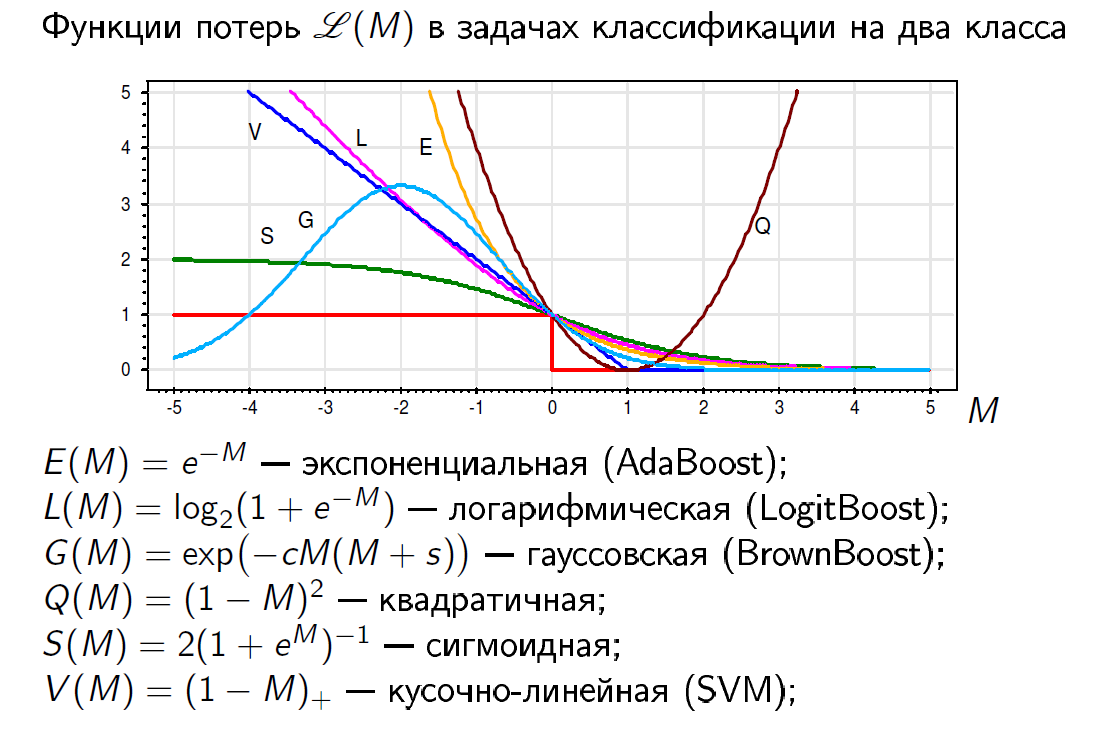

In [3]:
# Loss functions
Image('pics/Boosting_Loss_Functions.sng', height=600, width=600)

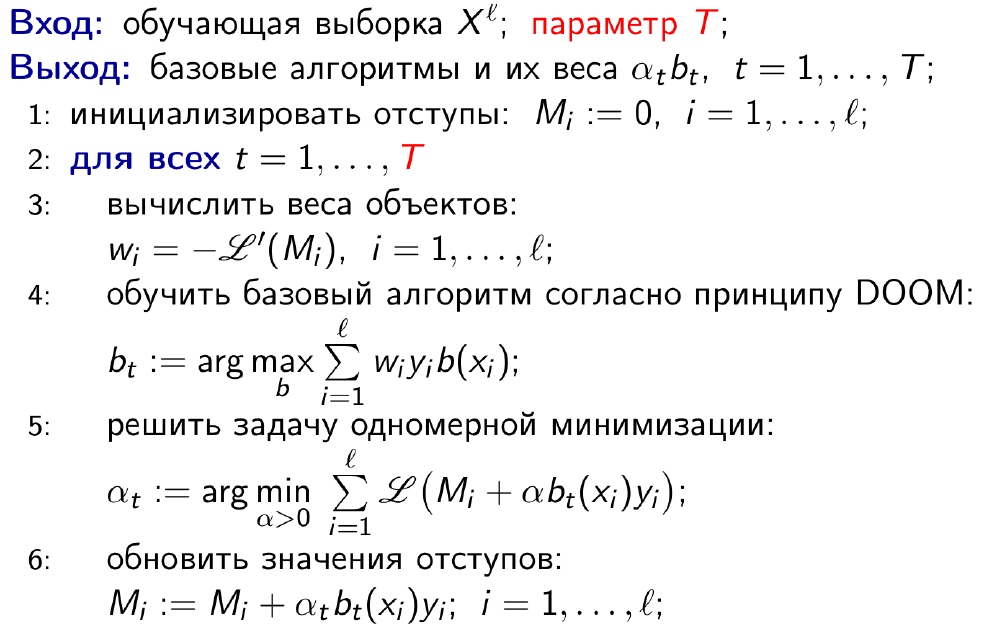

In [4]:
# Boosting
Image('pics/Boosting.png', height=600, width=600)

### Градиентный бустинг

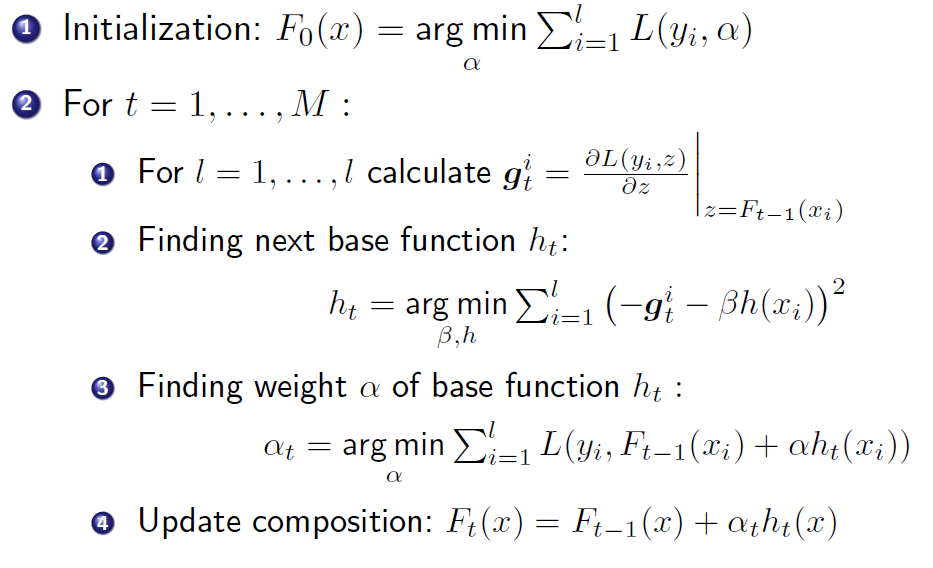

In [5]:
# Gradient Boosting
Image('pics/GBM.png', height=600, width=600)

### Пошаговый пример работы градиентного бустинга

##### Регрессия

C помощью GBM восстанавливаем зашумленную функцию $y=cos(x) + \varepsilon, \varepsilon \sim N(0,\dfrac{1}{5}), x \in [-5, 5]$

<img src='pics/gbm1.png'>

Запустим GBM и будем рисовать два типа графиков: актуальное приближение $\hat{f}(x)$ (синий график), а также каждое построенное дерево $\hat{f}_t(x)$ на своих псевдо-остатках (зеленый график). Номер графика соответствует номеру итерации:

<img src='pics/gbm2.png'>

<img src='pics/gbm3.png'>

Ко второй итерации наши деревья повторили основную форму функции. Однако, на первой итерации мы видим, что алгоритм построил только "левую ветвь" функции. Почему так происходит?

***Интерактивная демка, как GBM приближает функции: http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html***

##### Классификация

Варианты классификационных функций потерь:

***Logistic Loss:*** 
    $$L(y,f) = log(1 + exp(-2yf))$$
***Adaboost Loss:***
    $$L(y, f) = exp(-yf)$$

<img src='pics/gbm7.png'>

Решаем игрушечную задачу классификации, в качестве функции потерь выберем Logistic Loss:

<img src='pics/gbm4.png'>

<img src='pics/gbm5.png'>

<img src='pics/gbm6.png'>

На псевдо-остатках видно, что у нас есть достаточно много корректно классифицированных наблюдений, и какое-то количество наблюдений с большими ошибками, которые появились из-за шума в данных.

### Немного теоретических задач про GBDT

***Задача 1***

Что будет если обучать алгоритмы не на антиградиент, а на градиент в задаче регресии? Бинарной классификации? Насколько полезны будут получаться результаты?

***Задача 2***

Вы обучали градиентный бустинг, причём y-ки были в обучающей выборке были только положительные. Могут ли у вас получится отрицательные предсказания на тесте? А в бэггинге?

## Hand made Adaptive Gradient Boosting

**Необходимо реализовать класс `Adaboost`** (для решения задачи классификации)

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    - `n_estimators` - количество базовых моделей (решающих пней) в ансамбле;
    - `max_depth` - максимальная глубина дерева (по умолчанию - `None`);
    
- класс имеет методы `fit` и `predict`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `Adaboost`, представляющий собой ансамбль базовых моделей, обученный по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов;

In [10]:
class Adaboost(BaseEstimator):
    """
    Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses DecisionTreeClassifier. 
    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used. 
    max_depth: int
        Максимальная глубина решающего дерева в составе ансамбля. 
    """
    def __init__(self, n_estimators=5, max_depth=1, random_state=0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.alphas = []
        self.clfs = []
        self.random_state = random_state

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Инициализируем веса как 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        self.alphas = []
        
        # Последовательное обучение слабых моделей
        for _ in range(self.n_estimators):
            clf = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            clf.fit(X, y, sample_weight=w)
            
            predictions = clf.predict(X)
            min_error = sum(w[y != predictions])
            
            # Рассчитайте параметр alpha, с помощью которого происходит обновление весов объектов обучающей выборки
            # Alpha можно считать аппроксимацией "эффективности" алгоритма
            alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-10))
            
            # Обновите веса объектов обучающей выбрки
            # Ошибочно классифицированные объекты получат б`ольшие веса, чем корректно классифицированные объекты
            w *= np.exp(-alpha * y * predictions)
            
            # Нормализуем обновлённые веса
            w /= np.sum(w)
            
            # Сохраним слабую модель и её параметр alpha в список
            self.clfs.append(clf)
            self.alphas.append(alpha)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        
        # От каждой слабой модели нужно получить предсказания
        for alpha, clf in zip(self.alphas, self.clfs):
            # Просуммируем взвешенные с параметром alpha значения предсказаний 
            predictions = clf.predict(X).reshape(n_samples, 1)
            y_pred += alpha * predictions

        # Результирующий класс определяется знаком взвешенной суммы предсказаний слабых моделей
        y_pred = np.sign(y_pred).flatten()

        return y_pred

In [26]:
data = load_digits()
X = data.data
y = data.target
digit1 = 1
digit2 = 8
idx = np.append(np.where(y == digit1)[0], np.where(y == digit2)[0])
y = data.target[idx]
# Сменим метки классов на {-1, 1}
y[y == digit1] = -1
y[y == digit2] = 1
X = data.data[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

n_estimators = 12
clf = Adaboost(n_estimators=n_estimators, max_depth=1,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

base_clf = DecisionTreeClassifier(random_state=42, max_depth=1)
base_clf.fit(X_train, y_train)
y_pred_base = base_clf.predict(X_test)

print ("Decision Stump accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_base)))
print ("AdaBoost with {} estimators accuracy: {:.5f}".format(n_estimators, accuracy_score(y_test, y_pred)))

Decision Stump accuracy: 0.77528
AdaBoost with 12 estimators accuracy: 0.91011


In [25]:
## scikit-learn version:
ada = AdaBoostClassifier(base_estimator=base_clf,
                        n_estimators=n_estimators, random_state=42,
                        algorithm='SAMME')
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print ("Scikit-learn' AdaBoost with {} estimators accuracy: {:.5f}".format(n_estimators, accuracy_score(y_test, y_pred_ada)))

Scikit-learn' AdaBoost with 12 estimators accuracy: 0.91011


### Заключение

Ноутбук составлен по мотивам:
1. <a href="https://habrahabr.ru/company/ods/blog/327250/#postanovka-ml-zadachi"> Open Data Science, открытый курс машинного обучения. Тема 10 </a>
2. <a href="https://github.com/esokolov/ml-course-msu/tree/master/ML15-spring/lecture-notes"> Лекции Евгения Соколова </a>
3. <a href="https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending/"> Блог Александра Дьяконова </a>


### Обратная связь

<a href="https://docs.google.com/forms/d/e/1FAIpQLSfraHKZKZ4NJp1-KKCb5w0qQtXjtK76IkXWz9hwMM2AG9qH_A/viewform"> Оцените семинар </a>
